# Sujet 5 : Analyse des dialogues dans l'Avare de Molière

__Rappel du contexte du sujet__ :

L’Observatoire de la vie littéraire ([OBVIL](http://obvil.sorbonne-universite.site/obvil/presentation)) promeut une approche de l'analyse des textes littéraires fondée sur le numérique. 
Dans le cadre du [Projet Molière](http://obvil.sorbonne-universite.site/projets/projet-moliere), des pièces de cet auteur ont été numérisées et sont accessibles librement dans différents formats utilisables par un programme informatique.  

Grâce à ces numérisations, il est possible d'écrire des programmes pour réaliser des analyses syntaxiques et sémantiques. Ce sujet se propose de reproduire une étude réalisée par l'OBVIL sur les dialogues de l'Avare de Molière.

__Rappel des objectifs de ce sujet__ :

1. Classez les personnages selon la quantité de parole grâce à une analyse syntaxique du texte (scènes / répliques / mots). En particulier, quel est celui qui parle le plus ? Quel est celui qui ne parle pas du tout ? Attention, les noms des personnages ne sont pas forcément homogènes (casse et accents par exemple).
2. Réalisez un graphique qui montrera le nombre de mots que chaque acteur prononce dans chaque scène. Pour cela, vous pouvez vous inspirer de l'[étude de l'Avare de Molière réalisée par l'OBVIL](https://obvil.sorbonne-universite.fr/corpus/moliere/moliere_avare) (graphe de gauche). Dans ce graphique, les lignes sont de longueur égale et la hauteur représente le nombre de mots prononcés au total dans la scène. La largeur de chaque rectangle indique le pourcentage de la scène qu’un acteur occupe.  
3. Facultatif : Construisez un graphe d’interlocution permettant de visualiser les échanges entre les personnages. Pour cela, vous pouvez vous inspirer de l'[étude de l'Avare de Molière réalisée par l'OBVIL](https://obvil.sorbonne-universite.fr/corpus/moliere/moliere_avare) (graphe de droite).

La version numérisée que l'on se propose d'utiliser est le fichier texte au format markdown disponible ici [moliere_avare](http://dramacode.github.io/markdown/moliere_avare.txt).

In [1]:
data_url = "http://dramacode.github.io/markdown/moliere_avare.txt"

On va s'assurer qu'un fichier texte en local au format markdown contienne la pièce. Si le fichier "moliere_avare.md" existe on considère que c'est bon et s'il n'existe pas nous allons télécharger le contenu disponible à l'URL renseignée ci-dessus et l'écrire dans ce fichier local "moliere_avare.md".  

In [2]:
from os import path as pth
import requests

local_filename = "moliere_avare.md"
# Si le fichier csv des données d'incidence existe en local
# il n'est pas nécessaire de le télécharger par l'URL
if not pth.exists(local_filename):
  print("Le fichier local contenant la pièce de théâtre n'existe pas.")
  # Si le fichier n'existe pas en local dans le dossier courant
  # nous téléchargons les données et les écrivons
  # dans un fichier en local
  # Téléchargement des données
  response = requests.get(data_url)
  # Ecriture des données téléchargées dans le fichier local
  with open(local_filename, "wb") as f:
    f.write(response.content)

Maintenant que nous sommes assurés d'avoir un fichier en local contenant le texte de l'Avare dont on va faire l'analyse, on va donc l'ouvrir, parcourir son contenu et le traiter au fur et à mesure.

Ce que l'on sait déjà c'est que l'on va devoir créer une structure de données pour l'analyse.
On va passer par la bibliothèque Pandas et la création d'un dataframe, permettant de différencier les différents personnages et de qualifier leur "activité" au travers des différents actes et scènes. Néanmoins, après avoir parcouru le web, il est recommandé de passer par une structure intermédiaire pour la création du dataframe pandas. Nous allons choisir la structure de données native de python des dictionnaires en tant que structure de données intermédiaire. 

Il y a plusieurs choses auxquelles il est déjà nécessaire de penser vis-à-vis de la problématique posée et des représentations graphiques demandées, notamment celle relative à la question facultative.

Pour commencer, afin d'obtenir une bonne lisibilité des graphiques, il sera intéressant d'associer à chaque personnage une couleur différente.

Ensuite, la question facultative demande de déterminer à qui s'adresse chaque réplique afin d'avoir le graphe directionnel des interactions entre les personnages de la pièce. La structure de données devra donc permettre de savoir pour chaque réplique l'auteur mais aussi le destinataire de cette dernière. Ce sont des informations assez simples à obtenir mais à prendre en compte dans la manière de "parser" le fichier texte.

In [3]:
# On va d'ores et déjà utiliser une instruction afin que les graphiques s'affichent directement au sein du notebook
%matplotlib inline

In [4]:
# On déclare l'utilisation de la bibliothèque pandas et on crée également le dictionnaire
# qui va nous servir d'intermédiaire avant la création du dataframe pandas
import pandas as pd
# Le dictionnaire établi une structure en tableau à 5 colonnes permettant d'enregistrer
# l'auteur, le destinataire, l'acte, la scène, ainsi que la longueur en termes de mots 
# pour chaque réplique de la pièce
avareAnalysisDict = {'author':[],'recipient':[],'act':[],'scene':[],'speech_length':[]}
textDataSynthesisTableDf = None

# Nous créons également d'ores et déjà un dictionnaire des personnages de la scène
# permettant d'enregistrer les informations de liens avec les autres personnages
# de définir une couleur de représentation.

# Ce dictionnaire est initialisé vide car il sera rempli en utilisant le nom de chaque personnage
# comme clés associées à des valeurs qui seront des dictionnaires à deux entrées
# 'links' donnant les liens avec les autres personnages sous la forme d'une liste
# 'color' permettant de régler une couleur de représentation
avarePersoDict = {}

Afin de parser le fichier en s'appuyant notamment sur les symboles de titres utilisés par le format Markdown,
il nous faut avoir recours à l'utilisation d'un outil d'analyse des expressions régulières (cf. [Wikipedia_Expression_régulière](https://fr.wikipedia.org/wiki/Expression_r%C3%A9guli%C3%A8re)). La bibliothèque
[re](https://docs.python.org/3/library/re.html) disponible nativement dans python permet de faire ce travail.
Un rapide parcours du fichier montre que:
- les actes sont indiqués par des titres header 2, par une ligne commençant par ##
- les scènes sont indiquées par des titres header 3, par une ligne commençant par ###
- que les personnages d'une scène sont donnés sur la ligne suivant l'indication de la scène
- que la ligne précédant chaque réplique contient le "nom" de son auteur en majuscule

Voici un extrait illustrant ces propos:\
"\
_\##_ _Acte_ _Premier_.


_\### Scène Première.\
Valère, Élise_


    VALÈRE.
_Hé quoi, charmante Élise, vous devenez mélancolique, après les obligeantes assurances que vous avez eu la bonté de me donner de votre foi ?Je vous vois soupirer, hélas, au milieu de ma joie !Est-ce du regret, dites-moi, de m'avoir fait heureux ? et vous repentez-vous de cet engagement où mes feux ont pu vous contraindre ?_

    ÉLISE.
_Non, Valère, je ne puis pas me repentir de tout ce que je fais pour vous. Je m'y sens entraîner par une trop douce puissance, et je n'ai pas même la force de souhaiter que les choses ne fussent pas. Mais, à vous dire vrai, le succès me donne de l'inquiétude ; et je crains fort de vous aimer un peu plus que je ne devrais._
\
"

*Nota Bene*:
En continuant à travailler sur le sujet et en approfdondissant le parcours du texte, on peut se rendre compte qu'il y a parfois quelques indications de mise en scène qui viennent perturber ce schéma. Différente options s'offrent à nous:
- modifier le texte afin d'utiliser les mécanismes du markdown et mettre ces indications en italiques ou en gras --> utilisations de balises permettant de reconnaître facilement ces éléments
- ou bien repérer les numéros de ces lignes car il n'y en pas beaucoup afin de les ignorer (il nous faudra alors un moyen de connaître dans les fonctions d'analyse le numéro de la ligne du fichier en cours d'analyse.)
- pour être plus générique, l'idéal serait d'avoir un traitement intelligent, un réseaux de neurones par exemple spécialisé dans l'analyse du langage pour identifier ces éléments de mis en scène.

De plus les lignes indiquant la fin des actes sont également à ignorer en tant que réplique. Il y a au moins une scène ne donnant pas la liste des personnages, Harpagon étant le seul protagoniste, il faudra prendre en compte ce cas. Pour finir, deux lignes du fichier texte posent encore un problème:
- une ligne du fichier texte possède à sa fin, une déclaration de fin d'acte, ce qui tranche avec le schéma global,
- la dernière ligne du texte comprend la balise indiquant la fin de la pièce.

On traitera ces deux cas particulier dans la fonction de comptage des mots d'une ligne de texte.

In [5]:
# Déclaration des numéros de lignes à ignorer
playInstructionsLineNumbersList = [201, 204, 213, 251, 272, 384, 623, 782, 815, 1280, 1283,\
                                   1342, 1369, 1411, 1527, 1610, 1633, 1665, 1866, 1874, 1970, \
                                  2299, 2319, 2327, 2357, 2521, 2524]

In [6]:
import re
import copy

In [7]:
# Chaîne de caractère indiquant le début d'analyse et de récupération des personnages
persoCaptureStartLine = "# ACTEURS."
# L'expression régulière suivante permet de valider qu'une chaîne de caractère
# contenue dans une ligne lue correspond à la ligne précédant la définition
# de la liste des personnages
m = re.search('(?<=# )ACTEURS\.$', persoCaptureStartLine)
m.group(0)

'ACTEURS.'

En effet, le résultats obtenus n'est pas un objet null, à savoir une valeur None en python

In [8]:
# Exemple d'une ligne de la liste des personnages
persoLineExample = " – Harpagon, Père de Cléante et d'Élise, et Amoureux de Mariane."
# L'expression régulière proposée est la suivante
# On cherche une chaîne de caractères commencant par une majuscule --> [A-ZÀ-Ÿ]{1}
# potentiellement accentuée et ensuite composées de lettres potentiellement
# accentuées elles aussi, contenant des espaces, des virgules, des apostrophes --> [a-zA-ZÀ-ÿ\s,\']+
# et précédée d'un espace suivi d'un tiret suivi d'un espace (ce n'est pas le tiret du 6) --> (?<=\s–\s)
# , chaîne de caractères qui ne sera pas capturée
m1 = re.search('(?<=\s–\s)[A-ZÀ-Ÿ]{1}[a-zA-ZÀ-ÿ\s,\']+',persoLineExample)
m1.group(0)

"Harpagon, Père de Cléante et d'Élise, et Amoureux de Mariane"

Voici un lien vers un site de test en ligne d'expressions régulières python \([regexp_test](https://pythex.org/)\) qui a aidé à mettre en place l'expression régulière précédente.

In [9]:
# Fonction qui permet d'extraire la liste des personnages
# de la stocker dans un dictionnaire en parcourant ligne par ligne
# un fichier texte passé en entrée.
def fill_perso_dict(fileToAnalyse, emptyPersoDict):
  """
    Fonction remplissant un dictionnaire d'entrée avec la liste
    des personnages de la pièce de théâtre lue dans le fichier
    passé en entrée. On considère que le fichier en entrée est lu
    à partir du début, de sa première ligne.
    
    :param fileToAnalyse: pointeur obtenu par ouverture d'un fichier
    :param emptyPersoDict: dictionnaire à remplir par la fonction
    :return: numéro de la dernière ligne lue
  """
  lineNum = 0
  currentLine = fileToAnalyse.readline()
  lineNum += 1
  isStartPersoListLine = False
  while (currentLine and not isStartPersoListLine):
    m = re.search('(?<=# )ACTEURS\.$', currentLine)
    if m is not None:
      isStartPersoListLine = True
    currentLine = fileToAnalyse.readline()
    lineNum += 1
    
  # La lecture s'est arrêtée car la ligne de début de définition de la liste des personnages a été rencontrée.
  # Nous avons néanmoins lu la ligne suivante qui est obligatoirement un personnage.
  # Nous devons maintenant lire ligne par ligne, la liste des personnages au format suivant:
  # "- NomPersonnage, lien, lien, ..."
  # Ainsi dès que la ligne ne commence plus par un tiret nous pouvons arrêter la lecture et le remplissage
  # du dictionnaire.
  isAPersoLine = True
  # On extrait la chaîne de caractères qui nous intéresse
  m = re.search('(?<=\s–\s)[A-ZÀ-Ÿ]{1}[a-zA-ZÀ-ÿ\s,\']+', persoLineExample)
  extractedString = m.group(0)
  while (currentLine and isAPersoLine):
    # Traitement de la ligne courante qui est obligatoirement
    # une ligne listant un personnage de la pièce.
    # Comme le montre l'exemple au-dessus, le nom ainsi que
    # les différents types de liens sont séparés par une virgule.
    parts = extractedString.split(',')
    # La ligne au-dessus crée une liste dont chaque élément
    # est séparé par des virgules
    # typiquement "tata, titi, toto".split(',') --> ['tata', ' titi', ' toto']
    # Création d'un dictionnaire vide temporaire pour enregistrer les liens
    # ainsi que la couleur à paramétrer
    persoCaracs = {"links":[],"color":None}
    # On va traiter la ligne particulière qui introduit
    # le commissaire ainsi que son clerc
    m = re.match("le commissaire", parts[0], re.IGNORECASE)
    if not m:
      # Ce n'est pas la ligne du commissaire
      # Le premier élément donne le nom du personnage, indice 0 de la liste
      # Les éléments suivants donnent les liens avec les autres personnages
      # On parcours le reste de ces derniers
      for elt in parts[1:]:
        # En regardant cette partie dans le fichier,
        # on voit que soit les parties commencent
        # par un espace et une lettre,
        # soit un espace et un "et" que l'on ne
        # souhaite pas capturer
        # On vérifie si l'élément commence par " et " ou non
        if elt.startswith(" et "):
          # L'élément commence bien par " et "
          # on enlève cette partie
          currentLink = elt[4:]
        else:
          # Ce n'est pas le cas, on enlève juste
          # l'espace
          currentLink = elt[1:]
        persoCaracs["links"].append(currentLink)
      # Fin de la boucle for
      # On enregistre le dictionnaire temporaire des caractéristiques
      # du personnage courant rempli, dans le dictionnaire
      # global des personnages
      emptyPersoDict[parts[0]] = persoCaracs
    else:
      # C'est la ligne du commissaire,
      # la seconde partie définit le personnage du clerc
      # et commence par " et " 
      emptyPersoDict[parts[0]] = persoCaracs
      # On fait une copie profonde pour ne pas
      # que l'objet partage la même adresse mémoire
      clercCaracs = copy.deepcopy(persoCaracs)
      clercCaracs["links"].append("assistant du commissaire")
      emptyPersoDict[parts[1][4:]] = clercCaracs
    
    currentLine = fileToAnalyse.readline()
    lineNum += 1
    m = re.search('(?<=\s–\s)[A-ZÀ-Ÿ]{1}[a-zA-ZÀ-ÿ\s,\']+', currentLine)
    if m is not None:
      extractedString = m.group(0)
    else:
      isAPersoLine = False
    
    # Fin de la boucle while
    
  return lineNum

Définition de la fonction permettant de compter le nombre de mots d'une ligne constituant une réplique. Pour implémenter celle-ci nous nous sommes apuuyer sur des informations glannées au travers de la consultation de plusieurs pages internet et notamment la suivante [geeksforgeeks_comptage_de_mots_dans_une_phrase](https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/). Nous nous sommes également appuyer sur le site de test des expressions régulières et avons également fait des tests dans la ligne de commande python.
Pour traiter plus facilement le comptage des mots, nous allons nous servir du module natif string de python et allons donc importer celui-ci, pour utiliser l'atribut punctuation.

In [10]:
import string

In [11]:
def count_words(speechLine):
  """
    Fonction qui compte le nombre de mots contenus dans une ligne de texte.
    
    :param speechLine: ligne de texte en entrée dont il faut compter le nombre de mots
    :return: nombre de mots contenu dans la chaîne de caractère analysée
  """
  # Création d'une variable temporaire contenant la chaîne de caractère à traiter
  strToProcess = speechLine
  # Définition de l'expression régulière permettant d'exclure la déclaration de fin d'acte
  # à la fin de la ligne dans le cas particulier, on cherche un enchaînement de n'importe
  # quels caractères suivi d'un texte de la forme "Fin du nième Acte"
  patternExcludingActEndDeclaration = re.compile('(.+)(?=Fin du [a-zA-ZÀ-ÿ]+ Acte)')
  # Définition de l'expression régulière permettant d'exclure la déclaration de fin de la pièce
  # sur le même principe que la précédente
  patternExcludingPieceEndDeclaration = re.compile('(.+)(?=< Fin >)')
  # Réalisons le matching du premier pattern
  m = patternExcludingActEndDeclaration.match(speechLine)
  # Si le résultat n'est pas vide c'est que nous sommes dans le cas particulier
  # et qu'il faut travailler sur la chaîne résultat de la fonction match.
  if m:
    strToProcess = m.group(0)
    
  # Maintenant réalisons le matching du second pattern
  m1 = patternExcludingPieceEndDeclaration.match(speechLine)
  if m1:
    strToProcess = m1.group(0)
  # Maintenant, grâce au module string, contruisons une expression régulière qui va chercher toute suite
  # de plus de 1 caractère excluant les espaces et signes de ponctuations 
  wordsPattern = re.compile("[^{}\s]+".format(string.punctuation))
  # Traitons la chaîne de caractères avec la fonction de regexp findall
  # qui va extraire toutes les occurances du pattern recherché.
  # Cela va nous donner en sortie la liste des mots de la chaîne traitée
  # en considérant par exemple l'article "l'", la contraction du pronom je en "j'"
  # comme des mots.
  speechPartWordsList = re.findall(wordsPattern,strToProcess)
  # Le nombre de mots est donc la taille de cette liste,
  # retournons la en sortie.
  return len(speechPartWordsList)
    

Définition de la fonction principale d'analyse du fichier texte générant un tableau de données de synthèse.
Pour la création d'un dataframe pandas à partir d'un dictionnaire cf. [DataFrame.from_dict](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html).

In [12]:
import pandas as pd
def generate_text_synthesis_data_table(fileToAnalyse, persoDict, emptyAnalysisDict, lineNum):
  """
    Fonction principale d'analyse du texte générant un dataframe pandas
    de synthèse des informations permettant l'analyse globale.
    
    :param fileToAnalyse: pointeur obtenu par ouverture d'un fichier
    :param persoDict: dictionnaire donnant la liste des personnages de la pièce
    :param emptyAnalysisDict: dictionnaire à remplir par la fonction
    :param lineNum: numéro de le ligne à partir de laquelle nous commencons la lecture
    :return: dataframe pandas dont le template est donné par le dictionnaire
  """
  currentLine = fileToAnalyse.readline()
  lineNum += 1
  # Expression régulière de détection de déclaration des actes
  # Ligne qui commence par exactement 2 #, ni plus ni moins, donc tout autre caractère qu'un #
  actLinePattern = re.compile('^#{2}[^#]')
  # Expression régulière de détection de déclaration des scènes
  # Ligne qui commence par exactement 3 #, ni plus ni moins, donc tout autre caractère qu'un #
  sceneLinePattern = re.compile('^#{3}[^#]')
  # Variable pour enregistrer le numéro de l'acte courant
  actNum = 0
  # Variable pour enregistrer le numéro de la scène courante
  sceneNum = 0
  # Variable indiquant si la ligne précédente déclare une scène
  previousLineIsScene = False
  # Variable contenant l'auteur courant de la réplique analysée
  # Nous l'initialisons à la valeur vide None
  currentAuthor = None
  # Variable donnant le nombre de mots de la réplique courante
  # analysée. On l'initialise à 0.
  currentSpeechLen = 0
  
  # Boucle principale de parcours du fichier texte
  while (currentLine):
    if actLinePattern.match(currentLine):
      # Déclaration d'un acte de la pièce
      # On incrémente le numéro d'acte
      actNum += 1
      # Si ce n'est pas le premier acte,
      # il faut traiter le cas de la dernière réplique de
      # de la dernière scène de l'acte précédent.
      # On considère que l'auteur courant s'adresse forcément
      # au dernier auteur enregistré.
      if actNum > 1:
        # Récupération du dernier élément de la colonne des auteurs
        # qui est l'auteur de la réplique précédente
        previousAuthor = emptyAnalysisDict['author'][-1]
        if len(scenePersoList)==1:
          # Si la liste des personnages ne contient qu'un
          # seul protagoniste, c'est la scène qui fait exception
          # avec Harpagon.
          previousAuthor = 'Harpagon'
        emptyAnalysisDict['author'].append(currentAuthor)
        emptyAnalysisDict['recipient'].append(previousAuthor)
        # On a incrémenté le numéro d'acte, il faut donc 
        # le décrémenté pour obtenir celui concerné
        # par la réplique considérée ici.
        emptyAnalysisDict['act'].append(actNum-1)
        emptyAnalysisDict['scene'].append(sceneNum)
        emptyAnalysisDict['speech_length'].append(currentSpeechLen)
      # On remet à zéro le numéro de la scène
      sceneNum = 0
    elif sceneLinePattern.match(currentLine):
      # Déclaration d'une scène de la pièce
      # On incrémente le numéro de scène
      sceneNum += 1
      # Si ce n'est pas la première scène de l'acte,
      # il faut traiter le cas de la dernière réplique.
      # On considère que l'auteur courant s'adresse forcément
      # au dernier auteur enregistré.
      if (sceneNum > 1):
        # Récupération du dernier élément de la colonne des auteurs
        # qui est l'auteur de la réplique précédente
        previousAuthor = emptyAnalysisDict['author'][-1]
        emptyAnalysisDict['author'].append(currentAuthor)
        emptyAnalysisDict['recipient'].append(previousAuthor)
        emptyAnalysisDict['act'].append(actNum)
        emptyAnalysisDict['scene'].append(sceneNum-1)
        emptyAnalysisDict['speech_length'].append(currentSpeechLen)
      
      # On met temporairement la variable
      # previousLineIsScene à vrai pour indiquer
      # que l'on a détecté le début d'une scène
      previousLineIsScene = True
      # On déclare la liste des protagonistes de la scène courante
      scenePersoList = []
      # On réinitialise les autres variables de l'auteur et de la taille d'une réplique
      currentAuthor = None
      currentSpeechLen = 0
    else:
      # La ligne courante est une ligne autre,
      # comme on a pu le voir dans l'exemple un peu plus haut
      # elle peut être:
      # - vide
      # - une déclaration des personnages de la scène
      # - une identification de l'auteur de la réplique qui va suivre
      # - une ligne composant une réplique
      # - une ligne donnant des indications sur la mise en scène
      # - une ligne indiquant la fin d'un acte
      if not previousLineIsScene:
        # La ligne courante ne contient forcément pas la liste des protagonistes de la scène
        # Testons si la ligne est vide auquel cas on peut quasiment passer directement à la suivante.
        # Notons qu'une chaîne de caractères vide est interprêtées par python comme une valeur booléénne fausse
        if currentLine:
          # La ligne n'est pas vide, c'est soit la déclaration de l'auteur d'une réplique,
          # soit une ligne constituant une réplique.
          # On va donc traiter cette ligne soit de manière à identifier l'auteur qui,
          # il faut le noter est le destinataire de la réplique de l'auteur précédent,
          # soit de manière à compter le nombre de mots total d'une réplique afin
          # de remplir avec toutes les informations glannées à cette étape
          # de synthèse des données de la pièce.
          # On peut noter également que l'on peut facilement différencier les lignes de répliques
          # des lignes donnant l'auteur d'une réplique. En effet, les lignes de répliques commencent
          # par une lettre majuscule tandis que les lignes donnant l'auteur d'une réplique
          # commencent par des espaces.
          if currentLine.startswith(" "):
            # La ligne commence avec un espace, elle déclare donc l'auteur d'une réplique
            # on va parcourir la liste des protagonistes de la scène et identifier l'auteur
            for perso in scenePersoList:
              # On fait une recherche ignorant si les lettres sont en majuscules ou minuscules
              # grâce à l'option passée à la fonction de recherche d'expression régulière
              # re.IGNORECASE
              m = re.search(perso, currentLine, re.IGNORECASE)
              if m:
                # le résultats de la recherche n'est pas vide
                # L'auteur est trouvé. Vérifions si quelqu'un
                # a déjà parlé dans la scène auquel cas l'auteur
                # courant est le destinataire de l'auteur précédent.
                if currentAuthor is not None:
                  # Il y avait déjà un auteur d'une réplique, currentAuthor
                  # le nouvel auteur est donc aussi le destinataire de la réplique précédente.
                  # On peut maintenant remplir le dictionnaire pour la réplique précédente,
                  # car nous avons toutes les informations nécessaires sur celles-ci.
                  # Pour rappel, la structure du dictionnaire,
                  # {'author':[],'recipient':[],'act':[],'scene':[],'speech_length':[]}
                  emptyAnalysisDict['author'].append(currentAuthor)
                  emptyAnalysisDict['recipient'].append(perso)
                  emptyAnalysisDict['act'].append(actNum)
                  emptyAnalysisDict['scene'].append(sceneNum)
                  emptyAnalysisDict['speech_length'].append(currentSpeechLen)
                  # On réinitialise la variable mesurant le nombre de mot d'une réplique
                  currentSpeechLen = 0
                # Fin du si sur le test de savoir si il y a un auteur d'une réplique
                # précédent                
                # Dans tous les cas l'auteur courant est donné par la valeur "perso"
                # qui a été trouvée dans la ligne
                currentAuthor = perso
          
          else:
            isNotActEndDeclarationLine = not currentLine.startswith("Fin du")
            isNotPlayInstructionRoleLine = lineNum not in playInstructionsLineNumbersList
            # Si nous ne sommes pas dans le cas d'une ligne de déclaration de fin d'acte
            # ou bien d'une ligne d'instructions de mise en scène, nous sommes
            # dans le cas d'une ligne qui constitue une réplique.
            # Dans ce cas, comptons le nombre de mots de celle-ci et ajoutons le au nombre de mots
            # déjà comptabilisé pour la réplique en cours.
            # Nous faison appel ici à une fonction spécialisée dans le comptage des mots d'une ligne.
            if isNotActEndDeclarationLine and isNotPlayInstructionRoleLine:
              # Afin d'illustrer le traitement et vérifier que tout se passe bien
              # nous allons afficher les sorties pour la première scène de l'acte premier
              nbWords = count_words(currentLine)
              #if actNum==1 and sceneNum==1:
              #  print("Ligne de dialogue : {}".format(currentLine))
              #  print("Nombre de mots comptés : {:d}".format(nbWords))
              currentSpeechLen += nbWords
              # Il faut tester si c'est la dernière ligne de la pièce
              # et mettre à jour le dictionnaire dans ce seul cas
              patternExcludingPieceEndDeclaration = re.compile('(.+)(?=< Fin >)')
              m = patternExcludingPieceEndDeclaration.match(currentLine)
              if m:
                # C'est la dernière ligne de texte de la pièce
                previousAuthor = emptyAnalysisDict['author'][-1]
                emptyAnalysisDict['author'].append(currentAuthor)
                emptyAnalysisDict['recipient'].append(previousAuthor)
                emptyAnalysisDict['act'].append(actNum)
                emptyAnalysisDict['scene'].append(sceneNum)
                emptyAnalysisDict['speech_length'].append(currentSpeechLen)
      
      else:
        # La ligne courante présente forcément les personnages de la scène
        # car c'est la ligne qui suit la déclaration de scène,
        # à l'exception d'une seule scène, la 7 de l'acte 4
        # On peut donc réduire l'analyse du texte à ces seuls
        # protagonistes.
        # Boucle sur les clés du dictionnaire de personnage
        # qui sont leur nom.

        # Si la ligne contient autre chose que des caractères "blancs"
        # espaces, tabulations, retour ligne etc...
        # ce n'est pas l'exception.
        if not re.match('^[\s]+$',currentLine):
          # La ligne n'est pas vide, ce n'est pas l'exception
          for namePerso in persoDict:
            # On vérifie si namePerso fait partie des protagonistes
            # Pour prendre en compte le problème avec les maitres/maîtres
            # il faut adapter name Perso pour être une expression régulière
            persoRegex = namePerso
            if namePerso.startswith("Maitre"):
              persoRegex = namePerso.replace('Maitre','Maître')
              
            m = re.search(persoRegex, currentLine, re.IGNORECASE)
            if m is not None:
              # Le résultat de la recherche n'est pas vide,
              # le personnage fait partie des protagonistes
              # on l'ajoute à la liste des personnages de la scène
              scenePersoList.append(m.group(0))
        else:
          # La ligne est vide on sait que c'est le cas particulier
          # le seul protagoniste est Harpagon
          scenePersoList.append('Harpagon')
        #print("*********************************")
        #print("Liste des personnages de la scène")
        #print("*********************************")
        #print(scenePersoList)
        #print("*********************************")
        # La ligne précédente n'est désormais plus une déclaration
        # de début de scène
        previousLineIsScene = False
    
    currentLine = fileToAnalyse.readline()
    # On lit une ligne on incrémente donc le numéro de la ligne courante dans le fichier
    lineNum += 1
    
  return pd.DataFrame.from_dict(emptyAnalysisDict)


In [13]:
# On ouvre le fichier local en lecture 'r' pour en faire l'analyse
# en utilisant l'instruction with qui se chargera de fermer
# le fichier une fois sortie de l'instruction.
# (pas d'erreur possible par oubli d'appel à l'instruction close)
# Un rapide coup d'oeil au fichier texte nous montre une organisation
# , des symboles en début de ligne etc, que l'on va utiliser pour "parser"
# le fichier, à savoir le lire de manière à ranger les données
# de manière intelligente dans une structure de données facilitant
# la manipulation et l'analyse.
with open(local_filename,'r') as avareFile:
  # On va commencer par parser le fichier afin de récupérer la liste des personnages
  lineNum = fill_perso_dict(avareFile, avarePersoDict)
  
  #print("##################################################")
  #print("Contenu du dictionnaire des personnages initialisé")
  #print("##################################################\n")
  #print(avarePersoDict)
  #print("\n##################################################")
  
  textDataSynthesisTableDf = generate_text_synthesis_data_table(avareFile, avarePersoDict, avareAnalysisDict, lineNum)

# Le tableau de données récapitulatif est maintenant prêt à être utilisé
# Affichons celui-ci
textDataSynthesisTableDf
  

Exception scene 7 of act 4
persosList : ['Harpagon']


act          author       recipient  scene  speech_length
0      1          Valère           Élise      1             58
1      1           Élise          Valère      1             68
2      1          Valère           Élise      1             14
3      1           Élise          Valère      1             51
4      1          Valère           Élise      1             45
5      1           Élise          Valère      1             26
6      1          Valère           Élise      1             70
7      1           Élise          Valère      1             63
8      1          Valère           Élise      1              4
9      1           Élise          Valère      1            224
10     1          Valère           Élise      1            138
11     1           Élise          Valère      1             22
12     1          Valère           Élise      1            215
13     1           Élise          Valère      1             24
14     1          Valère           Élise      1             86
15     1           Élise          Valère      1             13
16     1         Cléante           Élise      2             24
17     1           Élise         Cléante      2             14
18     1         Cléante           Élise      2             10
19     1           Élise         Cléante      2              2
20     1         Cléante           Élise      2            173
21     1           Élise         Cléante      2             11
22     1         Cléante           Élise      2             24
23     1           Élise         Cléante      2              8
24     1         Cléante           Élise      2             26
25     1           Élise         Cléante      2             43
26     1         Cléante           Élise      2             10
27     1           Élise         Cléante      2             13
28     1         Cléante           Élise      2            150
29     1           Élise         Cléante      2             27
..   ...             ...             ...    ...            ...
931    5        Harpagon          Valère      5              2
932    5          Valère  Maître Jacques      5              6
933    5  Maître Jacques        Harpagon      5              7
934    5        Harpagon          Valère      5             10
935    5          Valère        Harpagon      5             10
936    5        Harpagon          Valère      5              9
937    5         Cléante        Harpagon      6             41
938    5        Harpagon         Cléante      6              3
939    5         Cléante        Harpagon      6             47
940    5        Harpagon         Cléante      6              7
941    5         Cléante         Mariane      6             36
942    5         Mariane         Anselme      6             36
943    5         Anselme        Harpagon      6             61
944    5        Harpagon         Cléante      6             11
945    5         Cléante        Harpagon      6              6
946    5        Harpagon         Anselme      6             13
947    5         Anselme        Harpagon      6             13
948    5        Harpagon         Anselme      6             12
949    5         Anselme        Harpagon      6              8
950    5        Harpagon         Anselme      6             12
951    5         Anselme  le Commissaire      6             13
952    5  le Commissaire        Harpagon      6             14
953    5        Harpagon  le Commissaire      6              8
954    5  le Commissaire        Harpagon      6             12
955    5        Harpagon  Maître Jacques      6             12
956    5  Maître Jacques         Anselme      6             23
957    5         Anselme        Harpagon      6              8
958    5        Harpagon         Anselme      6              5
959    5         Anselme        Harpagon      6             11
960    5        Harpagon         Anselme      6              6

[961 rows x 5 columns]

Y-a-t-il des éléments à NaN ou null dans le tableau construit?

In [14]:
 textDataSynthesisTableDf[textDataSynthesisTableDf.isnull().any(axis=1)]

Empty DataFrame
Columns: [act, author, recipient, scene, speech_length]
Index: []

In [20]:
 textDataSynthesisTableDf[textDataSynthesisTableDf.isna().any(axis=1)]

Empty DataFrame
Columns: [act, author, recipient, scene, speech_length]
Index: []

## Réponse à la première question
Maintenant, nous pouvons répondre à la première question.

L'observation d'un premier résultat intermédiaire nous a paru suspect. Ce résultat était le suivant:
```
Harpagon a prononcé 6992 mots dans oute la pièce.
Cléante a prononcé 3555 mots dans oute la pièce.
Élise a prononcé 1067 mots dans oute la pièce.
Valère a prononcé 3016 mots dans oute la pièce.
Mariane a prononcé 910 mots dans oute la pièce.
Anselme a prononcé 517 mots dans oute la pièce.
Frosine a prononcé 2381 mots dans oute la pièce.
Maitre Simon a prononcé 0 mots dans oute la pièce.
Maitre Jacques a prononcé 0 mots dans oute la pièce.
La Flèche a prononcé 1520 mots dans oute la pièce.
Dame Claude a prononcé 0 mots dans oute la pièce.
Brindavoine a prononcé 43 mots dans oute la pièce.
La Merluche a prononcé 47 mots dans oute la pièce.
Le commissaire a prononcé 0 mots dans oute la pièce.
```
En effet, de trop nombreux personnages semblaient ne prononcer aucun mot de toutes la pièce. En regardant, de plus près, nous avons pu faire deux constatations:
- le commissaire est accompagné par un clerc qui n'a pas été enregistré dans la liste des personnages, il faut donc corriger l'analyse de la liste des personnages au début de la pièce pour prendre en compte ce cas,
- certains nom de personnage peuvent différer d'un caractère par exemple entre la liste au début et celui utiliser pour annoncer les auteurs de réplique, typiquement Maitre Simon de la liste de début devient MAÎTRE SIMON (non seulement, il est en majuscule mais il prend un ^), Le commissaire devient Le Commissaire dans les protagonistes des scènes
Nous avons donc corriger le code pour prendre en compte ces deux problèmes.

In [16]:
# On va parcourir le dictionnaire des personnages
# et compter le nombre total de mots prononcés
# pour chacun.
import numpy as np
persoList = []
persoNbWords = np.zeros(len(avarePersoDict),dtype=int)
#print(textDataSynthesisTableDf.shape)
for index, perso in enumerate(avarePersoDict):
  persoRegex = perso
  if perso.startswith("Maitre"):
    persoRegex = perso.replace('Maitre','Maître')
  m = textDataSynthesisTableDf['author'].str.match(persoRegex, case=False, na=False)
  tmpDf = textDataSynthesisTableDf[m].copy()
  persoList.append(perso)
  persoNbWords[index] = tmpDf['speech_length'].sum()

data = pd.DataFrame({"perso":persoList, "speech_length":persoNbWords})
    
sortedData = data.set_index('speech_length').sort_index()
sortedData
  


perso
speech_length                
0                 Dame Claude
0                   son clerc
43                Brindavoine
47                La Merluche
197              Maitre Simon
294            Le commissaire
517                   Anselme
910                   Mariane
1067                    Élise
1520                La Flèche
1668           Maitre Jacques
2370                  Frosine
2740                   Valère
3331                  Cléante
6160                 Harpagon

Nous pouvons désormais finir de répondre à la premiè question posée. Le personnage s'exprimant le plus dans la pièce de _L'Avare_ de Molière et qui est donc le protagoniste principal, n'est autre qu'**Harpagon**. Quant aux personnages ne s'exprimant pas, nous en avons deux, le **clerc** du commissaire ainsi que **Dame Claude** qui est la servante d'Harpagon.

## Réponse à la seconde question

On va utiliser le classement pour associer à chaque personnage de la pièce une couleur unique. On va donc reprendre le dictionnaire des personnages et régler la propriété de couleur.

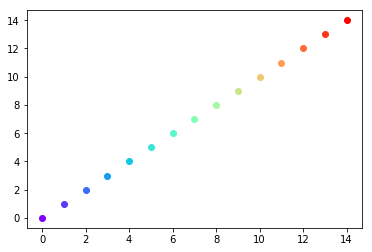

In [17]:
from matplotlib import pyplot as plt
from matplotlib import cm

# On affiche une sélection automatique de couleur dans une colormap
# matplotlib
nbPersos = len(persoList)
color = iter(cm.rainbow(np.linspace(0, 1, nbPersos)))
for i in range(nbPersos):
   c = next(color)
   plt.plot(i, i, 'o', c=c)

Cette sélection nous convient, on va affecter ces couleurs aux personnages.

In [18]:
color = iter(cm.rainbow(np.linspace(0, 1, nbPersos)))
for i in range(nbPersos):
  c = next(color)
  perso = sortedData["perso"].iloc[i]
  #print(perso)
  avarePersoDict[perso]["color"] = c

avarePersoDict

{'Harpagon': {'links': ["Père de Cléante et d'Élise", 'Amoureux de Mariane'],
  'color': array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])},
 'Cléante': {'links': ["Fils d'Harpagon", 'Amant de Mariane'],
  'color': array([1.        , 0.21994636, 0.11065268, 1.        ])},
 'Élise': {'links': ["Fille d'Harpagon", 'Amante de Valère'],
  'color': array([0.64509804, 0.9741386 , 0.62211282, 1.        ])},
 'Valère': {'links': ["Fils d'Anselme", "Amant d'Élise"],
  'color': array([1.        , 0.42912061, 0.21994636, 1.        ])},
 'Mariane': {'links': ['Amante de Cléante', "aimée d'Harpagon"],
  'color': array([0.50392157, 0.99998103, 0.70492555, 1.        ])},
 'Anselme': {'links': ['Père de Valère et de Mariane'],
  'color': array([0.35490196, 0.9741386 , 0.78292761, 1.        ])},
 'Frosine': {'links': ["Femme d'Intrigue"],
  'color': array([1.        , 0.61727822, 0.32653871, 1.        ])},
 'Maitre Simon': {'links': ['Courtier'],
  'color': array([0.07254902, 0.782927

En nous appuyant sur une page internet trouvée sur exemple d'affichage similaire à ce qui est fait dans l'étude \(à savoir un affichage par Acte, sous forme de barres horizontales pour chaque scène le composant donnant la répartition de la paroles entre les différents protagonistes de chaque scène\), on va pouvoir répondre à la seconde question. Voici un lien vers celle-ci: [geeksforgeeks_stacked-percentage-bar-plot](https://www.geeksforgeeks.org/stacked-percentage-bar-plot-in-matplotlib/).

act 1 persos ['Valère' 'Élise' 'Cléante' 'Harpagon' 'La Flèche']
   Cléante  Harpagon  La Flèche  Valère  scene  Élise
0        0         0          0     630      1    491
1      761         0          0       0      2    154
2        0       465        257       0      3      0
3      216      1150          0       0      4    162
4        0       273          0     707      5     36
act 2 persos ['Cléante' 'La Flèche' 'Maître Simon' 'Harpagon' 'Frosine']
   Cléante  Frosine  Harpagon  La Flèche  Maître Simon  scene
0      379        0         0        903             0      1
1      127        0       171         12           197      2
2        0        1        21          0             0      3
3        0      130         0        301             0      4
4        0     1496       555          0             0      5
act 3 persos ['Harpagon' 'Maître Jacques' 'La Merluche' 'Brindavoine' 'Élise' 'Cléante'
 'Valère' 'Frosine' 'Mariane']
   Brindavoine  Cléante  Frosine  Harpagon  La 

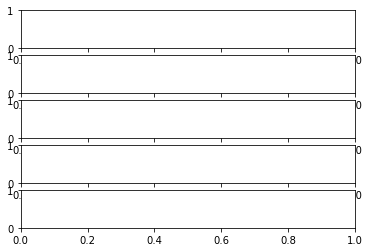

In [19]:
# Il va nous falloir compter le nombre d'actes de la pièce
# et faire une boucle sur ces derniers pour construire 
# un dataframe par acte à partir du dataframe global
# que dont on va caler la structure en fonction de
# l'exemple disponible sur la page.
# Le dataframe doit contenir une ligne par scène de l'acte
# courant et une colonne par protagoniste de la scène
actNums = pd.unique(textDataSynthesisTableDf["act"])
nbActs = actNums.size

fig = plt.subplots(nbActs, 1)

for actNum in actNums:
  actDf = textDataSynthesisTableDf[textDataSynthesisTableDf["act"]==float(actNum)].copy()
  #actDf
  sceneNums = pd.unique(actDf["scene"])
  actPersos = pd.unique(actDf["author"])
  print("act {0:} persos {1:}".format(actNum,actPersos))
  actDict = {"scene":[]}
  for perso in actPersos:
    # Création d'une colonne par personnage de l'acte
    actDict[perso] = []
  
  for sceneNum in sceneNums:
    actDict["scene"].append(sceneNum)
    sceneDf = actDf[actDf["scene"]==float(sceneNum)].copy()
    scenePersos = pd.unique(sceneDf["scene"])
    for perso in actPersos:
      tmpDf = sceneDf[sceneDf["author"]==perso].copy()
      if not tmpDf.empty:
        currentPersoNbWordsInScene = tmpDf["speech_length"].sum()
        #print(currentPersoNbWordsInScene)
        actDict[perso].append(currentPersoNbWordsInScene)
      else:
        actDict[perso].append(0)
  
  # Il faut ensuite transformer le dictionnaire d'acte en dataframe
  # on va en faire une version en pourcentage de paroles par scène.
  # Il faudra récupérer les valeurs du nombre de mots afin d'afficher
  # sur les graphiques.
  #print(actDict)
  actSceneSynthesisGraphDf = pd.DataFrame.from_dict(actDict)
  print(actSceneSynthesisGraphDf)
  subFig = plt.subplot(nbActs, 1, actNum)
  
  pass

Notes pour plus tard: lien stack overflow vers code de customisation de graphes de la bibliothèque python networkx
https://stackoverflow.com/questions/25639169/networkx-change-color-width-according-to-edge-attributes-inconsistent-result
lien github vers morceau de code ajoutant de la couleur et le réglage de l'épaisseur des arêtes sur un graphe
https://gist.github.com/AruniRC/2c53fe7680eeb578593ec816bbfb1653
Lien vers une page donnant un exemple d'affichage par ensemble de barres
https://www.geeksforgeeks.org/stacked-percentage-bar-plot-in-matplotlib/